Using device: cuda
Parameters: 58322314


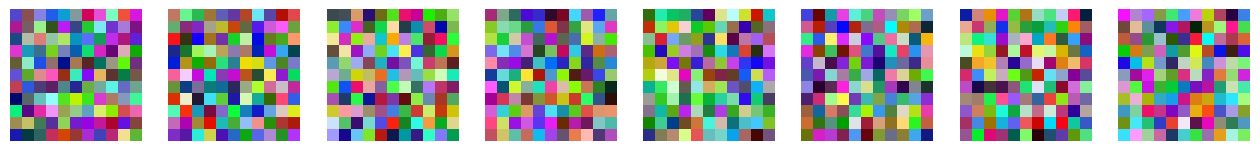

Epoch 1 [100/782] Loss: 2.3055
Epoch 1 [200/782] Loss: 2.2962
Epoch 1 [300/782] Loss: 2.1759
Epoch 1 [400/782] Loss: 2.1987
Epoch 1 [500/782] Loss: 1.8140
Epoch 1 [600/782] Loss: 1.5195
Epoch 1 [700/782] Loss: 1.7155
Epoch 1 finished in 143.7s | Train Loss 1.9848 Acc 0.2488 | Test Acc 0.4406
Epoch 2 [100/782] Loss: 1.5993
Epoch 2 [200/782] Loss: 1.4965
Epoch 2 [300/782] Loss: 1.3602
Epoch 2 [400/782] Loss: 1.5089
Epoch 2 [500/782] Loss: 1.4878
Epoch 2 [600/782] Loss: 1.1819
Epoch 2 [700/782] Loss: 1.2989
Epoch 2 finished in 143.1s | Train Loss 1.3753 Acc 0.4951 | Test Acc 0.5929
Epoch 3 [100/782] Loss: 1.2286
Epoch 3 [200/782] Loss: 1.2430
Epoch 3 [300/782] Loss: 1.1745
Epoch 3 [400/782] Loss: 0.9409
Epoch 3 [500/782] Loss: 1.0356
Epoch 3 [600/782] Loss: 0.9733
Epoch 3 [700/782] Loss: 0.9862
Epoch 3 finished in 145.6s | Train Loss 1.0597 Acc 0.6220 | Test Acc 0.6977
Epoch 4 [100/782] Loss: 0.9102
Epoch 4 [200/782] Loss: 0.8261
Epoch 4 [300/782] Loss: 1.0624
Epoch 4 [400/782] Loss: 0.88

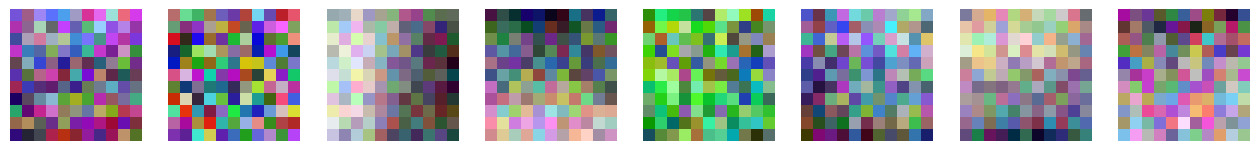

Final CIFAR-10 Test Accuracy: 0.7521


In [ ]:
# ============================
# AlexNet from Scratch (PyTorch) - Colab Notebook
# ============================

# -------------------------
# Imports
# -------------------------
import os, time
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# AlexNet Model
# -------------------------
class AlexNetScratch(nn.Module):
    def __init__(self, num_classes=10, use_lrn=True):
        super().__init__()
        self.use_lrn = use_lrn
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0) if use_lrn else nn.Identity(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0) if use_lrn else nn.Identity(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# -------------------------
# Dataset & Dataloaders
# -------------------------
def get_cifar10(batch_size=64, resize_to_224=True):
    train_tfms = []
    test_tfms = []

    if resize_to_224:
        train_tfms.append(transforms.Resize(224))
        test_tfms.append(transforms.Resize(224))

    train_tfms += [
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]
    test_tfms += [
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose(train_tfms))
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose(test_tfms))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

# -------------------------
# Training & Evaluation
# -------------------------
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in dataloader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    return correct/total

def train(model, train_loader, test_loader, device, epochs=5, lr=0.01):
    model = model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, correct, total = 0, 0, 0
        t0 = time.time()
        for i, (x,y) in enumerate(train_loader,1):
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = criterion(out,y)
            loss.backward()
            opt.step()

            running_loss += loss.item()*x.size(0)
            correct += out.argmax(1).eq(y).sum().item()
            total += y.size(0)

            if i % 100 == 0:
                print(f"Epoch {epoch} [{i}/{len(train_loader)}] Loss: {loss.item():.4f}")

        train_loss = running_loss/total
        train_acc = correct/total
        test_acc = evaluate(model,test_loader,device)
        print(f"Epoch {epoch} finished in {time.time()-t0:.1f}s | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Test Acc {test_acc:.4f}")

    return model

# -------------------------
# Visualization (Conv1 filters)
# -------------------------
def show_conv1_filters(model, n=8):
    conv1 = model.features[0]
    w = conv1.weight.detach().cpu().numpy()
    fig, axes = plt.subplots(1,n, figsize=(n*2,2))
    for i in range(n):
        f = w[i].transpose(1,2,0)
        f = (f-f.min())/(f.max()-f.min()+1e-5)
        axes[i].imshow(f)
        axes[i].axis("off")
    plt.show()

# -------------------------
# Run in Colab
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

train_loader, test_loader = get_cifar10(batch_size=64)
model = AlexNetScratch(num_classes=10, use_lrn=True)

print("Parameters:", sum(p.numel() for p in model.parameters()))
show_conv1_filters(model)

# Train few epochs
trained_model = train(model, train_loader, test_loader, device, epochs=5, lr=0.01)

# Show conv1 after training
show_conv1_filters(trained_model)

# Final test accuracy
acc = evaluate(trained_model, test_loader, device)
print("Final CIFAR-10 Test Accuracy:", acc)
